### 03 - HEAT STRESS OUTPUTS EXPLORATION

#### 03.1 - Libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 03.2 - Temporal patterns analysis

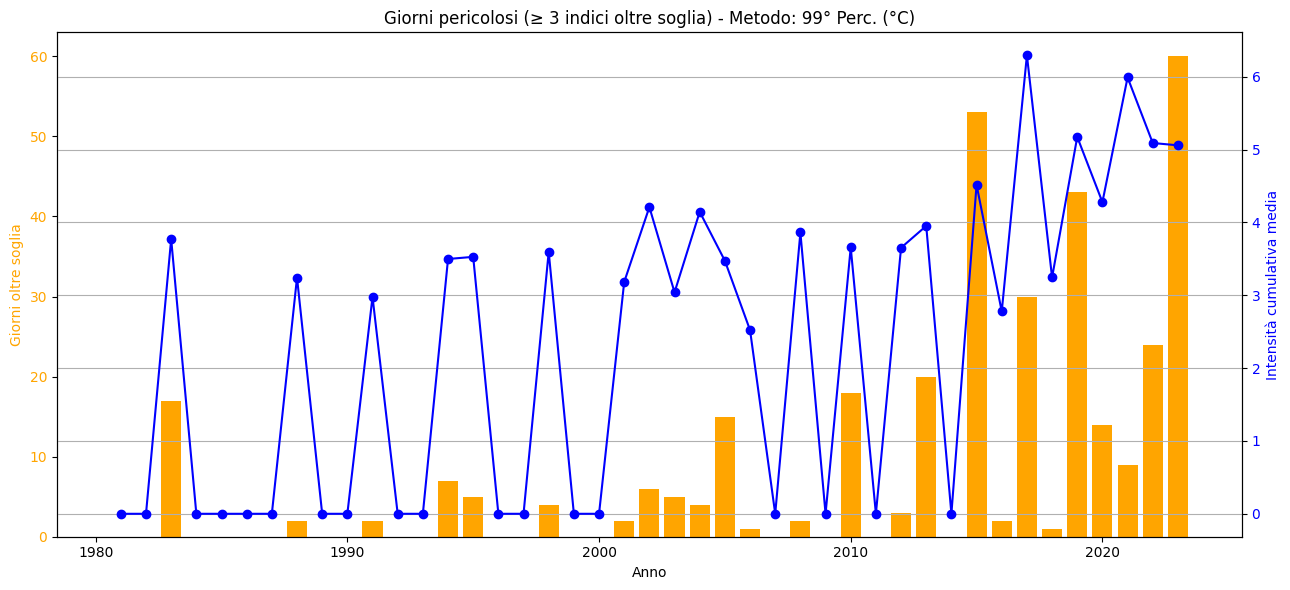

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== PARAMETRI MODIFICABILI ==========
csv_path = "heatstress_all_timestamps_all_years.csv"
metodo_statistico = "99° Perc. (°C)"  # Esempi: "Media (°C)", "Mediana (°C)", "95° Perc. (°C)", "99° Perc. (°C)", "Massimo (°C)"
min_soglie_superate = 3  # Numero minimo di indici che devono superare la soglia

# ========== CARICAMENTO DATI ==========
df = pd.read_csv(csv_path, parse_dates=["Timestamp"])
df["Anno"] = df["Timestamp"].dt.year

# Colonne dinamiche
col_valore = metodo_statistico
col_confronto = metodo_statistico.replace(" (°C)", "") + " > Soglia"
col_soglia = "Soglia (°C)"

# Controllo colonne
for col in [col_valore, col_confronto, col_soglia]:
    if col not in df.columns:
        raise ValueError(f"Colonna '{col}' non trovata nel file. Colonne disponibili: {df.columns.tolist()}")

# ========== COSTRUZIONE GIORNI PERICOLOSI ==========
giorni_pericolo = []

for giorno, gruppo in df.groupby("Timestamp"):
    gruppo = gruppo.set_index("Indice")
    bool_superata = gruppo[col_confronto] == "si"
    n_superata = bool_superata.sum()

    if n_superata >= min_soglie_superate:
        residui = (gruppo.loc[bool_superata, col_valore] - gruppo.loc[bool_superata, col_soglia]).sum()
        giorni_pericolo.append({
            "Data": giorno,
            "Anno": giorno.year,
            "n_superata": n_superata,
            "residuo_totale": residui
        })

# ========== AGGREGAZIONE PER ANNO ==========
df_pericolo = pd.DataFrame(giorni_pericolo)

# Crea range completo degli anni presenti nel CSV
anni_completi = range(df["Anno"].min(), df["Anno"].max() + 1)

# Raggruppa per anno e calcola conteggio e somma dei residui
summary = df_pericolo.groupby("Anno").agg({
    "Data": "count",
    "residuo_totale": "sum"
}).rename(columns={"Data": "giorni_pericolosi"}).reindex(anni_completi, fill_value=0)

# Pulizia: forza min 0 e gestione NaN
summary["giorni_pericolosi"] = summary["giorni_pericolosi"].clip(lower=0).fillna(0)
summary["residuo_totale"] = summary["residuo_totale"].fillna(0)
summary["intensità_media"] = summary.apply(
    lambda row: row["residuo_totale"] / row["giorni_pericolosi"] if row["giorni_pericolosi"] > 0 else 0,
    axis=1
)

# ========== GRAFICO ==========
fig, ax1 = plt.subplots(figsize=(13, 6))

# Barre dei giorni pericolosi
ax1.bar(summary.index, summary["giorni_pericolosi"], color="orange", label="Giorni oltre soglia")
ax1.set_ylabel("Giorni oltre soglia", color="orange")
ax1.set_xlabel("Anno")
ax1.tick_params(axis='y', labelcolor="orange")
ax1.set_ylim(bottom=0)  # Forza l’asse y a partire da zero

# Linea intensità media
ax2 = ax1.twinx()
ax2.plot(summary.index, summary["intensità_media"], color="blue", marker='o', label="Intensità media")
ax2.set_ylabel("Intensità cumulativa media", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

plt.title(f"Giorni pericolosi (≥ {min_soglie_superate} indici oltre soglia) - Metodo: {metodo_statistico}")
fig.tight_layout()
plt.grid(True)
plt.show()